策略梯度Policy Gradient算法，不同与DQN和DDQN, 是一种policy-based的算法，特点为直接显式地学习一种目标策略（不同于DQN学习价值，然后根据价值函数导出一个策略）

DQN是一个TD+NN的算法，那么PG就是MC(Monte-Carlo)+NN的算法

基于策略的方法首先需要将策略参数化。假设目标策略$\pi_{\theta}$是一个随机性策略，并且处处可微，其中$\theta$是对应的参数。我们可以用一个线性模型或者神经网络模型来为这样一个策略函数建模，输入某个状态，然后输出一个动作的概率分布。我们的目标是要寻找一个最优策略并最大化这个策略在环境中的期望回报。我们浮策略字习的目标函数定义为

$$J(\theta)=\mathbb{E}_{s_0}[V^{\pi_\theta}(s_0)]$$

其中，$s_0$表示初始状态。现在有了目标函数，我们将目标函数对策略

求导，得到导数后，就可以用梯度上升方法来最大化这个目标函数，

从而得到最优策略。

我第 3 章讲解过策略$\pi$下的状态访问分布（3.6节占用度量），在此用$\nu^\mathrm{\pi}$表示。然后我们对目标函数求梯度，可以得到如下式子，更详细的推导过程见<https://hrl.boyuai.com/chapter/2/%E7%AD%96%E7%95%A5%E6%A2%AF%E5%BA%A6%E7%AE%97%E6%B3%95#96-%E6%89%A9%E5%B1%95%E9%98%85%E8%AF%BB%EF%BC%9A%E7%AD%96%E7%95%A5%E6%A2%AF%E5%BA%A6%E8%AF%81%E6%98%8E>。

$$\begin{aligned}\nabla_{\theta}J(\theta)&\propto\sum_{s\in S}\nu^{\pi_\theta}(s)\sum_{a\in A}Q^{\pi_\theta}(s,a)\nabla_\theta\pi_\theta(a|s)\\&=\sum_{s\in S}\nu^{\pi_\theta}(s)\sum_{a\in A}\pi_\theta(a|s)Q^{\pi_\theta}(s,a)\frac{\nabla_\theta\pi_\theta(a|s)}{\pi_\theta(a|s)}\\&=\mathbb{E}_{\pi_\theta}[Q^{\pi_\theta}(s,a)\nabla_\theta\log\pi_\theta(a|s)]\end{aligned}$$

初始状态随机选择动作，进行迭代后得到奖励，再动态调整采取该动作的概率，

因此PG是on-policy算法

介绍REINFORCE算法，此算法采用了蒙特卡洛方法估计Q：

$$\nabla_\theta J(\theta)=\mathbb{E}_{\pi_0}\left[\sum_{t=0}^T\left(\sum_{t^{\prime}=t}^T\gamma^{t^{\prime}-t}r_{t^{\prime}}\right)\nabla_\theta\log\pi_\theta(a_t|s_t)\right]$$

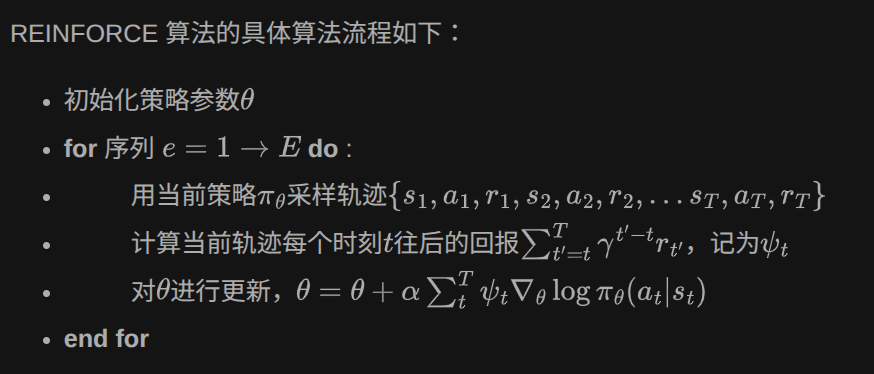

依然选择CartPole环境进行实验。

In [5]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device):
        self.policy_net = PolicyNet(state_dim, hidden_dim,
                                    action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),
                                          lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):
        """对动作进行离散概率分布并采样"""
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)  
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']
        """初始化G"""
        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):
            reward = reward_list[i]
            state = torch.tensor([state_list[i]],
                                 dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action)) # gather 提取沿着第一个维度计算采取的action对应的概率
            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度
        self.optimizer.step()
        


In [6]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = "CartPole-v1"
env = gym.make(env_name)
env.reset(seed = 0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma,
                  device)

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset(seed = 0)[0]
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _, __ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s, episode=1000, return=1238.800]


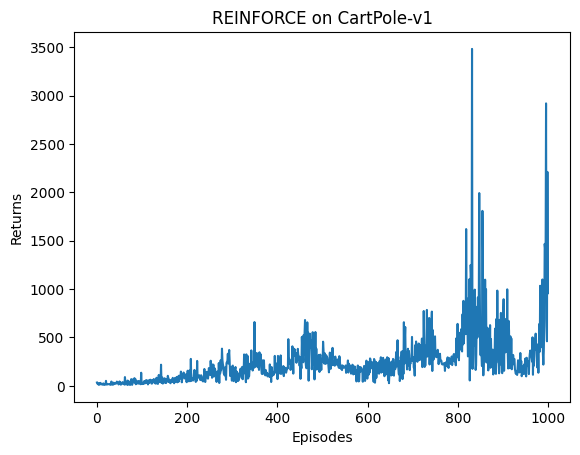

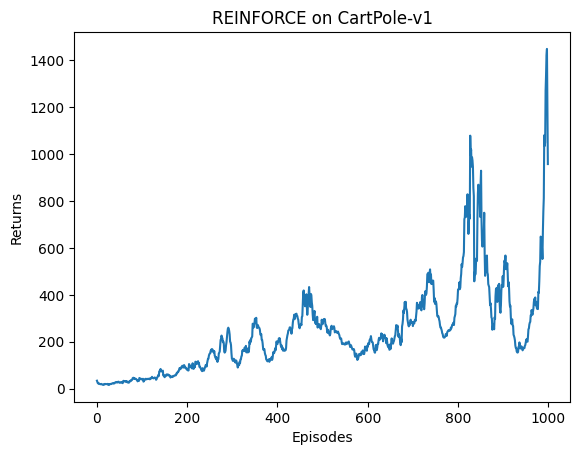

In [7]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()